# 1. You must give a better solution using any RL algorithm.

* 'Better' solution may vary depending on what you are aiming for. Define your own meaning of what a 'better' solution is.
* Any RL algorithms are allowed. (MC, SARSA, Q-learning, Double Q-learning, etc.)
* You are not allowed to use DRL algorithms. For this time, we limit our methods into traditional RL algorithms.
* You are encouraged to share ideas with others before the next session. If you share ideas, each of you should define your own meaning of 'better' solutions.
* Each person (or one person from a group) should present his/her/their ideas in the next session.

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.4 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
env = gym.make('Taxi-v3', render_mode='rgb_array') ### rgb array로 보이게 설정하는 것

array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
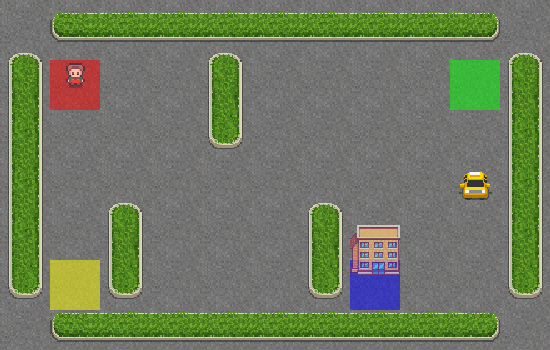

In [4]:
observation, info = env.reset(seed=500) ### 게임을 초기 화면으로 만들어 줌, 시드가 달라지면 게임이 달라짐
env.render() ### ndarray를 만들어서 보여줌

In [5]:
observation ### state을 나타내는 숫자이다.

283

In [6]:
info ### prob = 1.0 이라는 것은 action에 대해서 state이 변할 확률이 1.0 이다.

{'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}

In [7]:
print(env.observation_space.n)
print(env.action_space.n)

500
6


In [8]:
next_state, reward, terminated, truncated, info = env.step(1) ### 액션을 취함, 환경에서 step을 취하고 1을 썼다는 것은 action space 에서 north를 취한다는 것 (0은 south 1은 north 2는 east 3은 west)

array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
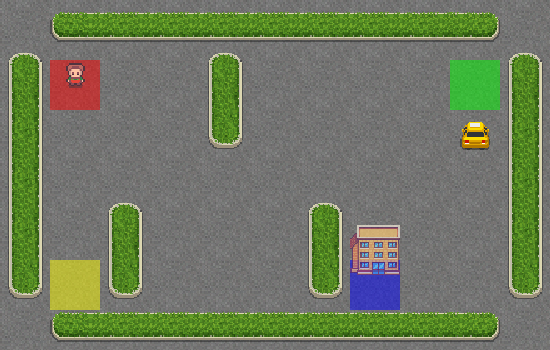

In [9]:
env.render() ### 현 state에 대한 env output이 나옴

In [10]:
print(next_state)
print(reward)
print(terminated) ### 게임이 끝났다는 것을 알림
print(truncated) ### 게임이 너무 길어질 경우를 생각해서 에피소드 하나가 200이 되지 않도록 제한
print(info)

183
-1
False
False
{'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}


## Q-learning

- Q-learning update rule: $Q(S_{t},A_{t}) \longleftarrow Q(S_{t},A_{t}) + \alpha \, [R + \gamma max_{a} Q(S_{t+1},a) - Q(S_{t},A_{t})]$

In [11]:
Q_table = np.zeros((env.observation_space.n, env.action_space.n)) ### 500 * 6 짜리 Q table 생성

In [12]:
def Q_learning_update_q(state, action, reward, next_state, Q_table, alpha, gamma):
    Q_table[state, action] += alpha * (reward + gamma*np.max(Q_table[next_state, :]) - Q_table[state, action])
    return Q_table

In [13]:
## Epsilon-greedy policy

def get_action(Q_table, state, epsilon):
    tmp = random.random() ### 0과 1사이의 수를 고름
    if tmp < epsilon:
        # random action with probability epsilon
        return np.random.randint(Q_table.shape[1])
    else:
        # greedy action with probability 1 - epsilon
        return np.argmax(Q_table[state])

In [14]:
def epsilon_schedule(episode, max_episode, initial_eps, final_eps):
    start, end = initial_eps, final_eps
    if episode < max_episode:
        return (start*(max_episode-episode) + end*episode) / max_episode
    else:
        return end

In [15]:
total_rewards = []
episode_lengths = []
max_episode = 2000
initial_epsilon = 1.0
final_epsilon = 0.05
alpha = 0.4
gamma = 1

for episode in range(max_episode):
    terminated = False
    truncated = False
    episode_reward = 0
    episode_length = 0

    epsilon = epsilon_schedule(episode, max_episode//2, initial_epsilon, final_epsilon) ### 왜 2로 나눌까?

    # Initialize the environment
    state, info = env.reset() ### seed를 고정하지 않고 랜덤으로 돌려서 각 에피소드를 다르게 만들어 준다.
    action = get_action(Q_table, state, epsilon)
    episode_length += 1

    while not terminated and not truncated:
        next_state, reward, terminated, truncated, info = env.step(action)
        Q_table = Q_learning_update_q(state, action, reward, next_state, Q_table, alpha, gamma)
        next_action = get_action(Q_table, next_state, epsilon)
        state = next_state
        action = next_action

        episode_reward += reward
        episode_length += 1

    total_rewards.append(episode_reward)
    episode_lengths.append(episode_length)


Text(0, 0.5, 'Episode Length')

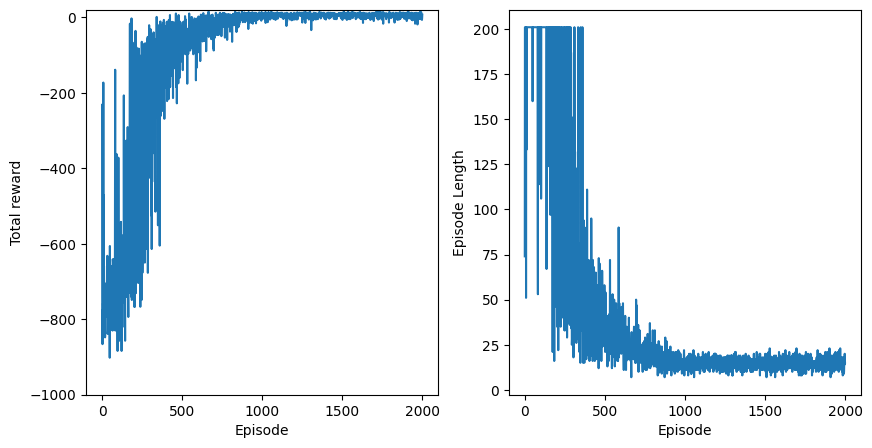

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(np.arange(max_episode), total_rewards, label='Q learning')
axes[0].set_ylim([-1000,20])
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total reward')

axes[1].plot(np.arange(max_episode), episode_lengths, label='Q learning')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Episode Length')

In [17]:
import PIL.Image
from IPython.display import Image

In [18]:
def play_and_save(Q_table, name='', seed=None):
    render_images = []

    state, _ = env.reset(seed=seed)
    image_array = env.render()
    render_images.append(PIL.Image.fromarray(image_array))

    size = image_array.shape[0], image_array.shape[1]
    terminated, truncated = False, False

    while not terminated and not truncated:
        action = np.argmax(Q_table[state])
        state, reward, terminated, truncated, _ = env.step(action)
        image_array = env.render()
        render_images.append(PIL.Image.fromarray(image_array))

    filename = 'play_'+name+'.gif'

    render_images[0].save(filename, save_all=True, optimize=False, append_images=render_images[1:], duration=500, loop=0)
    ## 저장되는 파일이름, 몰라, 몰라, append할 이미지들, 한 프레임이 넘어가기까지의 시간,
    print('GIF is made successfully!')

    return filename



In [19]:
saved_fname2 = play_and_save(Q_table, '2', seed=8)

GIF is made successfully!


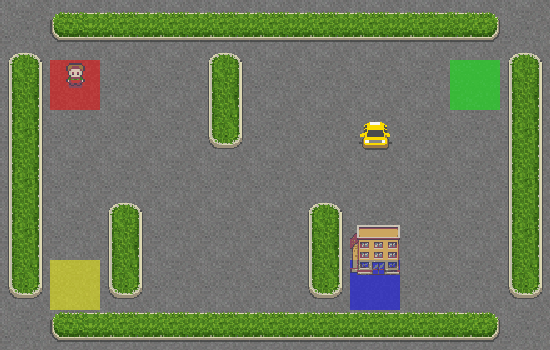

In [20]:
Image(open(saved_fname2,'rb').read())

## Double Q-learning

- Double Q-learning update rule

  $Q_{1}(S_{t},A_{t}) \longleftarrow Q_{1}(S_{t},A_{t}) + \alpha \, [R + \gamma Q_{2}(S_{t+1},argmax_{a}Q_{1}(S_{t+1},a) - Q_{1}(S_{t},A_{t})]$
$Q_{2}(S_{t},A_{t}) \longleftarrow Q_{2}(S_{t},A_{t}) + \alpha \, [R + \gamma Q_{1}(S_{t+1},argmax_{a}Q_{2}(S_{t+1},a) - Q_{2}(S_{t},A_{t})]$

  with 0.5 probability for each

In [21]:
Q_table1 = np.zeros((env.observation_space.n, env.action_space.n))
Q_table2 = np.zeros((env.observation_space.n, env.action_space.n))

In [22]:
def Double_Q_learning_update_q(state, action, reward, next_state, next_action, Q_table1, Q_table2, alpha, gamma):
    Q_table1[state, action] += alpha * (reward + gamma*Q_table2[next_state, next_action] - Q_table1[state, action])
    return Q_table

In [23]:
## Epsilon-greedy policy

def get_action(Q_table, state, epsilon):
    tmp = random.random() ### 0과 1사이의 수를 고름
    if tmp < epsilon:
        # random action with probability epsilon
        return np.random.randint(Q_table.shape[1])
    else:
        # greedy action with probability 1 - epsilon
        return np.argmax(Q_table[state])

In [24]:
def epsilon_schedule(episode, max_episode, initial_eps, final_eps):
    start, end = initial_eps, final_eps
    if episode < max_episode:
        return (start*(max_episode-episode) + end*episode) / max_episode
    else:
        return end

In [25]:
total_rewards = []
episode_lengths = []
max_episode = 2000
initial_epsilon = 1.0
final_epsilon = 0.05
alpha = 0.4
gamma = 1
prob = 0.5 # 0.5의 확률로 Q1 또는 Q2를 업데이트

for episode in range(max_episode):
    terminated = False
    truncated = False
    episode_reward = 0
    episode_length = 0

    epsilon = epsilon_schedule(episode, max_episode//2, initial_epsilon, final_epsilon) ### 왜 2로 나눌까?

    # Initialize the environment
    state, info = env.reset() ### seed를 고정하지 않고 랜덤으로 돌려서 각 에피소드를 다르게 만들어 준다.
    action = get_action(Q_table1 + Q_table2, state, epsilon)
    episode_length += 1

    while not terminated and not truncated:
        next_state, reward, terminated, truncated, info = env.step(action)
        temp = random.random()

        # 각각 0.5의 확률로 하나의 Q table을 업데이트
        if temp < prob:
          next_action = np.argmax(Q_table1[next_state,:])
          Q_table1 = Double_Q_learning_update_q(state, action, reward, next_state, next_action, Q_table1, Q_table2, alpha, gamma)
        else:
          next_action = np.argmax(Q_table2[next_state,:])
          Q_table2 = Double_Q_learning_update_q(state, action, reward, next_state, next_action, Q_table2, Q_table1, alpha, gamma)

        next_action = get_action(Q_table1 + Q_table2, state, epsilon)
        state = next_state
        action = next_action

        episode_reward += reward
        episode_length += 1

    total_rewards.append(episode_reward)
    episode_lengths.append(episode_length)


Text(0, 0.5, 'Episode Length')

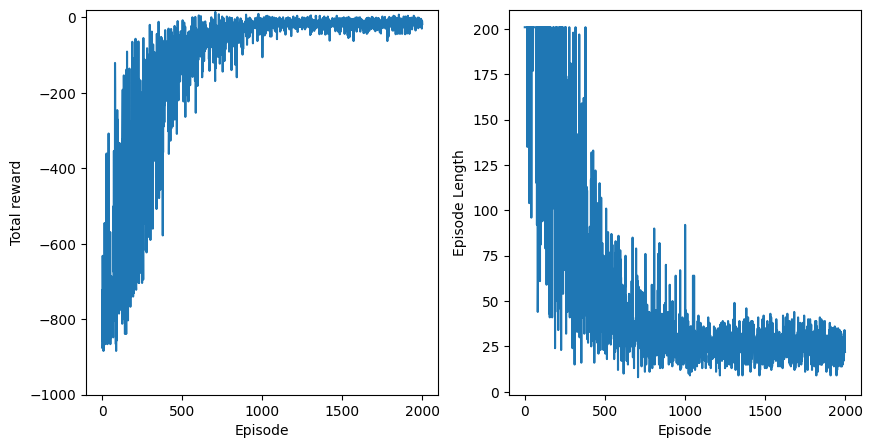

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].plot(np.arange(max_episode), total_rewards, label='Double Q learning')
axes[0].set_ylim([-1000,20])
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total reward')

axes[1].plot(np.arange(max_episode), episode_lengths, label='Double Q learning')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Episode Length')

In [27]:
saved_fname2 = play_and_save(Q_table1 + Q_table2, '2', seed=12)

GIF is made successfully!


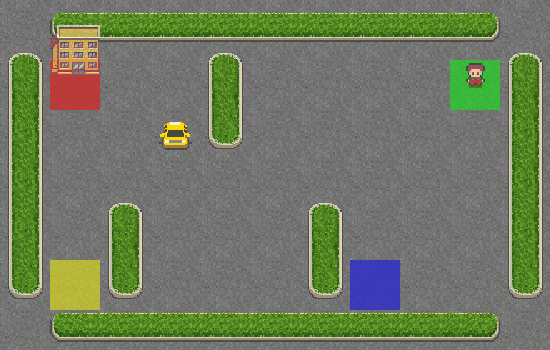

In [28]:
Image(open(saved_fname2,'rb').read())

# 2. [DIY problem] The following code is a way of choosing an action that is able to change the current state. However, this method does not give a good solution.
  - Why? Think about an answer. (Note: There is indeed an answer to this problem!!)
  - For this question, please ***do not share or discuss your ideas*** with others. Let's take a time to discuss the problem in the next section.
  - Furthermore, I wish to adhere to this action-choosing method. What I should change in the environment so that we can get a good solution with the action-choosing method?


[ans]

  액션 마스크를 통해서 이동할 수 있는 action들 중에서 greedy policy를 적용해서 action을 고르게 되면 학습 초반에 모든 action에 대한 exploration을 할 수 없다. 즉, 마스크로 인해서 임의로 action의 선택에 제한을 하면 제한된 action들이 왜 안 좋은 action들인지 학습을 하지 못하게 된다. 이것으로 인해서 제대로 된 학습을 하지 못해서 제자리에서 멈춰있는 결과를 얻게 되고 -200점을 얻은 에피소드가 많아지는 것도 그 이유이다. 그럼에도 -200점 이상의 에피소드도 조금씩 발견되는데, 그것은 운 좋게 한번씩 제대로 task를 수행했을 뿐이지 학습이 되었다는 것을 말해주지는 않는다.

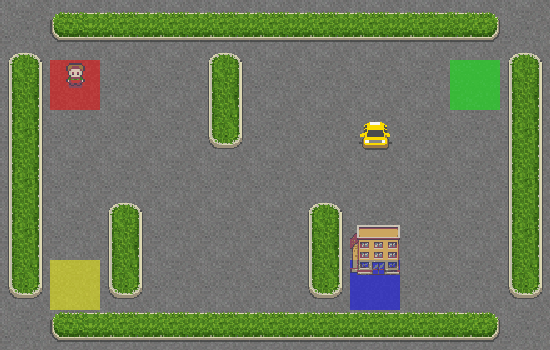

# 3. What are the roles of the hyperparameters, $\gamma$ and $\alpha$, for training SARSA? What would happend if I modify the values?
  - Bring your own thoughts and share them with us in the next session.
  - If possible, you are encouraged to show the supporting experiments for your thoughts.

## SARSA

- Sarsa update rule: $Q(S,A) \longleftarrow Q(S,A) + \alpha \, [R + \gamma Q(S',A') - Q(S,A)]$


In [29]:
## Reinforcement Learning is a Q-table updating method!
## This is why continuous state/action spaces are not able to solved using traditional RL methods.

Q_table = np.zeros((env.observation_space.n, env.action_space.n)) ### 500 * 6 짜리 Q table 생성

In [30]:
def sarsa_update_q(state, action, reward, next_state, next_action, Q_table, alpha, gamma):
    Q_table[state, action] += alpha * (reward + gamma*Q_table[next_state, next_action] - Q_table[state, action])
    return Q_table

In [31]:
## Epsilon-greedy policy

def get_action(Q_table, state, epsilon):
    tmp = random.random() ### 0과 1사이의 수를 고름
    if tmp < epsilon:
        # random action with probability epsilon
        return np.random.randint(Q_table.shape[1])
    else:
        # greedy action with probability 1 - epsilon
        return np.argmax(Q_table[state])

In [32]:
def epsilon_schedule(episode, max_episode, initial_eps, final_eps):
    start, end = initial_eps, final_eps
    if episode < max_episode:
        return (start*(max_episode-episode) + end*episode) / max_episode
    else:
        return end

In [46]:
total_rewards_array = []
episode_lengths_array = []
max_episode = 5000
initial_epsilon = 1.0
final_epsilon = 0.05
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
gamma = 1

for alpha in alphas:
  total_rewards = []
  episode_lengths = []
  for episode in range(max_episode):
      terminated = False
      truncated = False
      episode_reward = 0
      episode_length = 0

      epsilon = epsilon_schedule(episode, max_episode//2, initial_epsilon, final_epsilon) ### 왜 2로 나눌까?

      # Initialize the environment
      state, info = env.reset() ### seed를 고정하지 않고 랜덤으로 돌려서 각 에피소드를 다르게 만들어 준다.
      action = get_action(Q_table, state, epsilon)
      episode_length += 1

      while not terminated and not truncated:
          next_state, reward, terminated, truncated, info = env.step(action)
          next_action = get_action(Q_table, next_state, epsilon)
          Q_table = sarsa_update_q(state, action, reward, next_state, next_action, Q_table, alpha, gamma)
          state = next_state
          action = next_action

          episode_reward += reward
          episode_length += 1

      total_rewards.append(episode_reward)
      episode_lengths.append(episode_length)
  total_rewards_array.append(total_rewards)
  episode_lengths_array.append(episode_lengths)

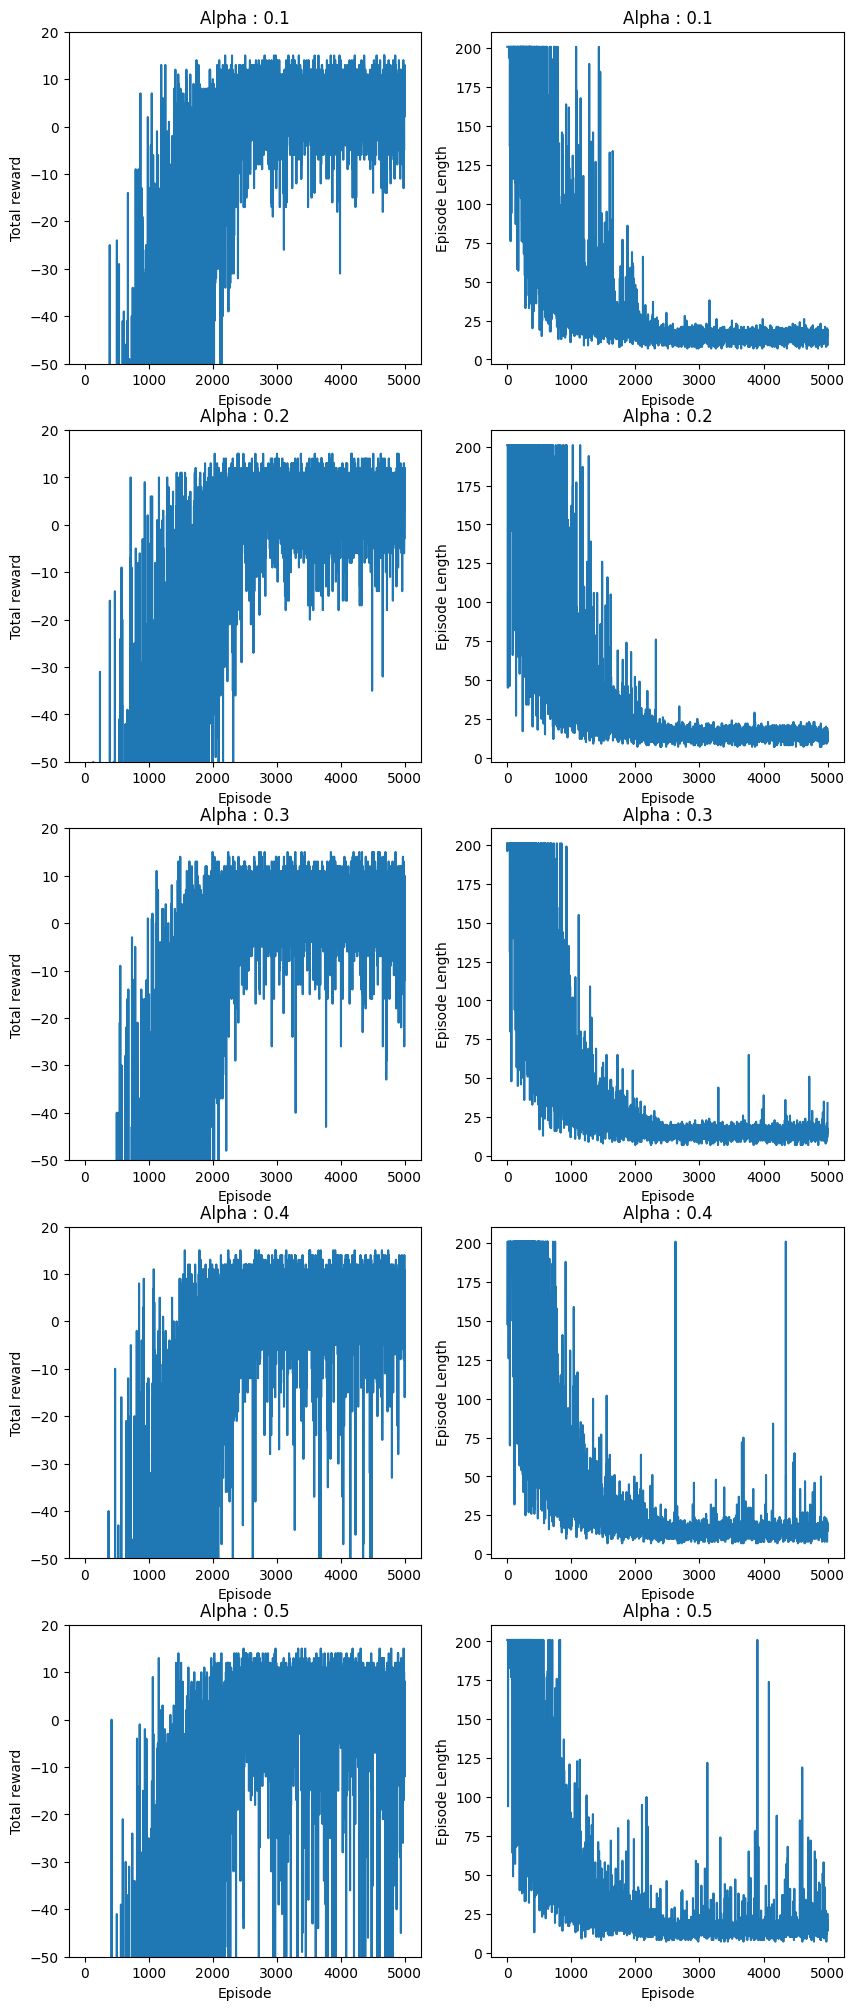

In [47]:
fig, axes = plt.subplots(nrows=len(total_rewards_array), ncols=2, figsize=(10,len(total_rewards_array)*5))
for i in range(5):
  axes[i,0].plot(np.arange(max_episode), total_rewards_array[i], label='SARSA')
  axes[i,0].set_ylim([-50,20])
  axes[i,0].set_xlabel('Episode')
  axes[i,0].set_ylabel('Total reward')
  axes[i,0].set_title(f'Alpha : {alphas[i]}')

  axes[i,1].plot(np.arange(max_episode), episode_lengths_array[i], label='SARSA')
  axes[i,1].set_xlabel('Episode')
  axes[i,1].set_ylabel('Episode Length')
  axes[i,1].set_title(f'Alpha : {alphas[i]}')

## 결과
alpha = 0.1, 0.2, 0.3, 0.4, 0.5 에 대해서 SARSA를 실행해본 결과,
학습이 더 빠르게 진행되는 것을 확인했다. 하지만 alpha값이 너무 커질 경우 q-value 업데이트를 너무 큰 폭으로 하게 되어서 학습은 빠르지만 안정성이 떨어져서 그래프가 튄다고 본다.

## SARSA

- Sarsa update rule: $Q(S,A) \longleftarrow Q(S,A) + \alpha \, [R + \gamma Q(S',A') - Q(S,A)]$


In [35]:
## Reinforcement Learning is a Q-table updating method!
## This is why continuous state/action spaces are not able to solved using traditional RL methods.

Q_table = np.zeros((env.observation_space.n, env.action_space.n)) ### 500 * 6 짜리 Q table 생성

In [36]:
def sarsa_update_q(state, action, reward, next_state, next_action, Q_table, alpha, gamma):
    Q_table[state, action] += alpha * (reward + gamma*Q_table[next_state, next_action] - Q_table[state, action])
    return Q_table

In [37]:
## Epsilon-greedy policy

def get_action(Q_table, state, epsilon):
    tmp = random.random() ### 0과 1사이의 수를 고름
    if tmp < epsilon:
        # random action with probability epsilon
        return np.random.randint(Q_table.shape[1])
    else:
        # greedy action with probability 1 - epsilon
        return np.argmax(Q_table[state])

In [38]:
def epsilon_schedule(episode, max_episode, initial_eps, final_eps):
    start, end = initial_eps, final_eps
    if episode < max_episode:
        return (start*(max_episode-episode) + end*episode) / max_episode
    else:
        return end

In [67]:
total_rewards_array = []
episode_lengths_array = []
max_episode = 5000
initial_epsilon = 1.0
final_epsilon = 0.05
alpha = 0.4
gammas = [1, 0.999, 0.99, 0.95]


for gamma in gammas:
  total_rewards = []
  episode_lengths = []
  for episode in range(max_episode):
      terminated = False
      truncated = False
      episode_reward = 0
      episode_length = 0

      epsilon = epsilon_schedule(episode, max_episode//2, initial_epsilon, final_epsilon) ### 왜 2로 나눌까?

      # Initialize the environment
      state, info = env.reset() ### seed를 고정하지 않고 랜덤으로 돌려서 각 에피소드를 다르게 만들어 준다.
      action = get_action(Q_table, state, epsilon)
      episode_length += 1

      while not terminated and not truncated:
          next_state, reward, terminated, truncated, info = env.step(action)
          next_action = get_action(Q_table, next_state, epsilon)
          Q_table = sarsa_update_q(state, action, reward, next_state, next_action, Q_table, alpha, gamma)
          state = next_state
          action = next_action

          episode_reward += reward
          episode_length += 1

      total_rewards.append(episode_reward)
      episode_lengths.append(episode_length)
  total_rewards_array.append(total_rewards)
  episode_lengths_array.append(episode_lengths)
  print(len(total_rewards_array))

1
2
3
4


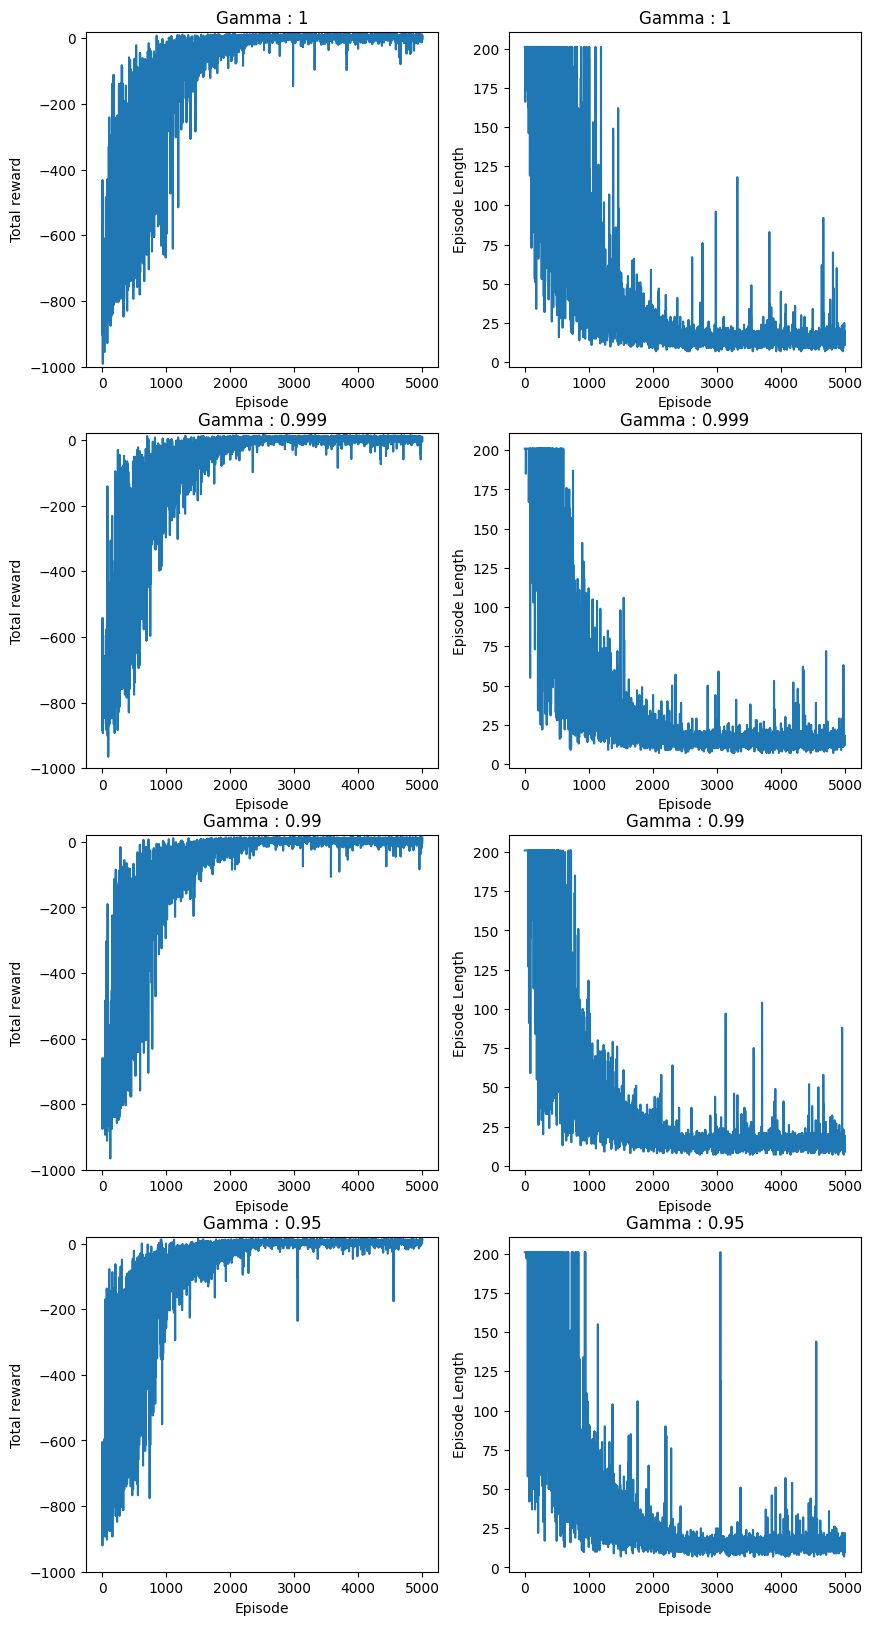

In [68]:
fig, axes = plt.subplots(nrows=len(total_rewards_array), ncols=2, figsize=(10,len(total_rewards_array)*5))
for i in range(len(total_rewards_array)): # row 가 1 일때는 axes 가 2차원 배열이 아니라 1차원으로 생성되어서 인덱싱이 실행 안된다.
  axes[i,0].plot(np.arange(max_episode), total_rewards_array[i], label='SARSA')
  axes[i,0].set_ylim([-1000,20])
  axes[i,0].set_xlabel('Episode')
  axes[i,0].set_ylabel('Total reward')
  axes[i,0].set_title(f'Gamma : {gammas[i]}')

  axes[i,1].plot(np.arange(max_episode), episode_lengths_array[i], label='SARSA')
  axes[i,1].set_xlabel('Episode')
  axes[i,1].set_ylabel('Episode Length')
  axes[i,1].set_title(f'Gamma : {gammas[i]}')

## 결과
각각의 gamma 값에 대해서 total reward와 episode length를 살펴본 결과
alpha = 0.1일 때는 그래프가 큰 차이를 보이지 않았지만,
alpha = 0.2일 때는 gamma 값이 줄어들수록 그래프가 튀는 결과.
alpha = 0.3일 때도 그래프가 튀었음.
alpha = 0.4일 때는 오히려 큰 차이가 없어서 혼란스럽.

기본적으로 gamma값이 줄어들수록 next state에 대한 q-value 값이 discount되기 때문에 과하게 줄어들 경우 잘못된 선택을 할 경우가 생겨서 그래프가 튀는 것으로 보인다.